In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jupyterthemes as jtplot
from geopy.geocoders import Nominatim
import re

%config InlineBackend.figure_format = 'retina'                                    # so you can see plots in HD :) 
#jtplot.style(theme='grade3', context='notebook', ticks=True, grid=True)

## extract data

In [2]:
df_2020 = pd.read_csv(r'data/raw/huie_surveyData_2020.csv')
df_2021 = pd.read_csv(r'data/raw/huie_surveyData_2021.csv')

print(f'The 2020 survey has {len(df_2020)} partcipants.')
print(f'The 2021 survey has {len(df_2021)} partcipants.')

The 2020 survey has 362 partcipants.
The 2021 survey has 961 partcipants.


## transform & clean data

In [3]:
REGIONS = np.array(
            ["Northland/Te Tai Tokerau"
            "Auckland/Tāmakimakaurau", 
            "Waikato",
            "Bay of Plenty/Te MoanaaToi",
            "Gisborne/Te Tai Rāwhiti",
            "Hawke's Bay/Te Mataua Māui",
            "Taranaki",
            "Manawatū",
            "Whanganui",
            "Wellington/Te WhanganuiaTara",
            "Tasman/Te TaioAorere",
            "Nelson/Whakatū",
            "Marlborough/Te Tauihuotewaka",
            "West Coast /Te Tai Poutini",
            "Canterbury/Waitaha",
            "Otago/Ōtākou",
            "Southland/Murihiku",
            "All regions of the North Island/Te IkaaMāui",
            "All regions of the South Island/Te Wai Pounamu",
            "All regions of Aotearoa/New Zealand"]
)

# define function to aggregate data based on the columns
def aggregate_regions(df_in, reg_cols):
    '''
    Takes raw df as input and outputs df with aggregated 
    regions for each entry in new location column
    '''
    df_out = df_in.copy()
    
    df_out = df_out.replace(np.nan, '', regex=True)                        # replace nans for easier agreggation
    df_out['location'] = df_out[reg_cols].T.agg(','.join)             # aggregation
    df_out = df_out.replace(',,', '', regex=True)                        # gets rid of double commas
    
    return df_out

 
# define function to get rid of first and last comma
def remove_comma(df_in, which):
    '''
    Inputs df from aggregate_regions output and removes the 
    '''
    df_out = df_in.copy()

    # track what comma to remove (index) based on which input
    ind = 0 if which == 'first'  else -1
    # remove comma with lambda function
    with_comma = [(lambda s: s[ind] == ',')(s) for s in df_in['location']]
    if which == 'first': 
        df_out['location'][with_comma] = df_out['location'][with_comma].map(lambda s: str(s)[1:])
    elif which == 'last':
        df_out['location'][with_comma] = df_out['location'][with_comma].map(lambda s: str(s)[:-1])
        
    return df_out

# define function to ensure that there's no entry with an empty location
def gis_quality_check(df_in):
    '''
    Checks for empty entries in the location column for input df_in
    '''
    
    print(f'='*60)
    print(f'Carrying out data quality check:')
    print(f'-'*35)
    
    is_loc_empty =  [(lambda s: s == '')(s) for s in df_in['location']]
    n_empty = len(df_in['location'][is_loc_empty])
                
    if n_empty == 0:
        print(f'The data has no empty entries in the location column')
        print(f'='*60)
    else:
        print(f'The data has {n_empty} empty entries in the location column')
        print(f'='*60)

# call region aggregator
region_cols = ['In which region(s) does your organisation operate (please choose all that apply)'] + [f'Unnamed: {j}' for j in range(14,32+1)]
df_2020 = aggregate_regions(df_2020, region_cols)

# call function to remove comma 
df_2020 = remove_comma(df_2020, which='first')
df_2020 = remove_comma(df_2020, which='last')

# call quality data function to check for empty entries
gis_quality_check(df_2020)
    
print(df_2020.loc[5, 'location'])
print(df_2020.loc[2, 'location'])

#[is_comma_first(val) for val in df_2020['location'].values]

Carrying out data quality check:
-----------------------------------
The data has no empty entries in the location column
Auckland/Tāmaki-makau-rau,Waikato,Manawatū-Whanganui,Wellington/Te Whanga-nui-a-TaraNelson/Whakatū,Canterbury/Waitaha,Otago/Ōtākou
Southland/Murihiku


## group data for counting regions

In [18]:
df_2020_grouped = df_2020.groupby('location')['Respondent ID'].size()

counts = df_2020_grouped.values
groups = np.array(df_2020_grouped.index)

generic_regions = [
    "All regions of the North Island/Te IkaaMāui",
    "All regions of the South Island/Te Wai Pounamu",
    "All regions of Aotearoa/New Zealand"
]

count_regions = {reg.split('/')[0]:0 for reg in REGIONS if reg not in generic_regions}

print(count_regions)
df_2020_grouped

{'Northland': 0, 'Waikato': 0, 'Bay of Plenty': 0, 'Gisborne': 0, "Hawke's Bay": 0, 'Taranaki': 0, 'Manawatū': 0, 'Whanganui': 0, 'Wellington': 0, 'Tasman': 0, 'Nelson': 0, 'Marlborough': 0, 'West Coast ': 0, 'Canterbury': 0, 'Otago': 0, 'Southland': 0}


location
All regions of Aotearoa/New Zealand                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      51
All regions of the North Island/Te Ika-a-Māui,All regions of the South Island/Te Wai Pounamu,All regions of Aotearoa/New Zealand                                                                                                                                                                                                                                                                                                                                                   

In [16]:
print(groups)

['All regions of Aotearoa/New Zealand'
 'All regions of the North Island/Te Ika-a-Māui,All regions of the South Island/Te Wai Pounamu,All regions of Aotearoa/New Zealand'
 'Auckland/Tāmaki-makau-rau'
 'Auckland/Tāmaki-makau-rau,All regions of Aotearoa/New Zealand'
 'Auckland/Tāmaki-makau-rau,Waikato'
 'Auckland/Tāmaki-makau-rau,Waikato,Bay of Plenty/Te Moana-a-Toi'
 'Auckland/Tāmaki-makau-rau,Waikato,Bay of Plenty/Te Moana-a-Toi,Wellington/Te Whanga-nui-a-Tara'
 "Auckland/Tāmaki-makau-rau,Waikato,Bay of Plenty/Te Moana-a-ToiHawke's Bay/Te Matau-a-Māui,TaranakiWellington/Te Whanga-nui-a-Tara,Tasman/Te Tai-o-Aorere,Nelson/Whakatū,Canterbury/Waitaha,Otago/Ōtākou,Southland/Murihiku"
 'Auckland/Tāmaki-makau-rau,Waikato,Manawatū-Whanganui,Wellington/Te Whanga-nui-a-Tara,Canterbury/Waitaha'
 'Auckland/Tāmaki-makau-rau,Waikato,Manawatū-Whanganui,Wellington/Te Whanga-nui-a-Tara,Canterbury/Waitaha,Otago/ŌtākouAll regions of Aotearoa/New Zealand'
 'Auckland/Tāmaki-makau-rau,Waikato,Manawatū-Whang

## draw map of Aotearoa

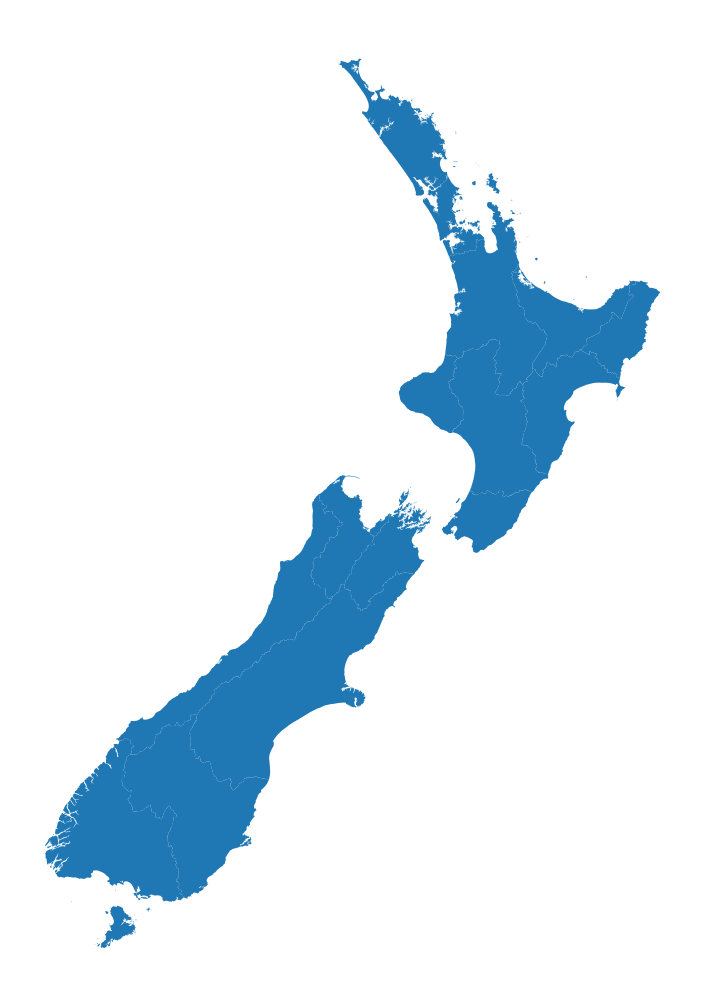

In [47]:
import geopandas as gpd

def extract_geodataframe(csv_fp, shp_fp):
    '''
    Reads the csv and shp files from NZ's regional councils and
    creates a geodataframe to plot the map of NZ. Files publicily available here:
    https://datafinder.stats.govt.nz/layer/106667-regional-council-2022-clipped-generalised/
    '''
    gdf_shp = gpd.read_file(csv_fp)
    gdf_csv = gpd.read_file(shp_fp)

    # get rid of redundand columns and of extra region wording
    gdf_csv = gdf_csv[["REGC2022_V1_00_NAME"]]
    gdf_csv = gdf_csv.replace('Region', '', regex=True)                                                      
    # join two dataframes and get rid of Outside NZ region
    gdf_map = gdf_csv.merge(gdf_shp, left_index=True, right_index=True)
    gdf_map = gdf_map.drop(gdf_map.index[-1], axis=0)
    gdf_map = gpd.GeoDataFrame(gdf_map)#, crs="EPSG:4326", geometry=geometry)
    
    return gdf_map

# define function to draw NZ map
def draw_map(gdf, count=None):
    '''
    Draws map of input dataframe (assume multipolygon) geometry
    '''
    
    fig, ax = plt.subplots(figsize=(24,9))
    gdf.plot(ax=ax)
    
    plt.axis("off")
    plt.show()
    
    

# call function to extract geodataframe of NZ's regional councils
csv_filepath = "data/gis/regional-council-2022-clipped-generalised.shx"
shp_filepath = "data/gis/regional_council_2022_clipped_csv.csv"
gdf_map = extract_geodataframe(csv_filepath, shp_filepath)

gdf_map

# call map drawing function
draw_map(gdf_map)


In [44]:
gdf_map['geometry']

TypeError: no numeric data to plot

## questions for quotes 

In [6]:
text = 'The COVID-19 pandemic has had multiple structural/operational/financial impacts upon our tangata whenua, community and voluntary organisations in Aotearoa/New Zealand. That considered, the pandemic may have also had impacts on the wellbeing and emotional/morale status and stress levels of people in these organisations. Can you tell us a short story about your experiences?'

if False:
    print(df_2021[text].values)